In [1]:
import numpy as np 
import os
import pandas as pd 
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_eager_execution()
import shutil
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageOps


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers
from keras.api._v2.keras.optimizers import legacy
from keras.src.optimizers.legacy.adam import Adam
import random
random.seed(42)
np.random.seed(42)
tf.random.set_random_seed(42)
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from scipy.stats import norm
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calculate_rank_accuracy(probe, gallery, probe_labels, gallery_labels):
    rank_1_count = 0
    rank_5_count = 0

    # Calculate similarities for each probe
    for i, probe_vec in enumerate(probe):
        probe_label_idx = np.argmax(probe_labels[i])  # Get the index of the class label for the probe
        similarities = []
        for j, gallery_vec in enumerate(gallery):
            gallery_label_idx = np.argmax(gallery_labels[j])  # Get the index of the class label for the gallery
            # Calculate cosine distance (1 - similarity) and store it with the corresponding gallery label index
            similarities.append((1 - cosine(probe_vec, gallery_vec), gallery_label_idx))
        
        # Sort by distance, closest first
        similarities.sort(reverse=True)

        # Check if the correct label index is within top 5
        top_5_labels = [label for _, label in similarities[:5]]
        if probe_label_idx in top_5_labels:
            rank_5_count += 1
            if probe_label_idx == similarities[0][1]:
                rank_1_count += 1
    
    # Calculate and return accuracies
    rank_1_accuracy = rank_1_count / len(probe)
    rank_5_accuracy = rank_5_count / len(probe)
    return rank_1_accuracy, rank_5_accuracy

In [3]:
def calculate_similarity_scores(probe_features, gallery_features, probe_labels, gallery_labels):
    # Flatten the features if they are not already 1D
    probe_features_flat = probe_features.reshape(probe_features.shape[0], -1)
    gallery_features_flat = gallery_features.reshape(gallery_features.shape[0], -1)

    similarity_scores = []
    labels = []

    # Compare each probe feature to each gallery feature
    for i, probe_feature in enumerate(probe_features_flat):
        probe_label_idx = np.argmax(probe_labels[i])  # Assuming one-hot encoding, get the actual label index
        for j, gallery_feature in enumerate(gallery_features_flat):
            gallery_label_idx = np.argmax(gallery_labels[j])  # Get the actual label index for gallery

            # Calculate the cosine similarity score
            score = cosine_similarity([probe_feature], [gallery_feature])[0][0]
            similarity_scores.append(score)

            # If the labels match, it's a genuine pair, otherwise it's an impostor
            labels.append(1 if probe_label_idx == gallery_label_idx else 0)

    return similarity_scores, labels

In [19]:
def calculate_rank_accuracy_from_scores(similarity_scores, labels):
    rank_1_count = 0
    rank_5_count = 0
    unique_probes = np.unique(labels)

    # Iterate over each unique probe label
    for probe in unique_probes:
        # Filter scores and labels for the current probe
        current_probe_scores = [score for score, label in zip(similarity_scores, labels) if label == probe]
        current_probe_indices = [i for i, label in enumerate(labels) if label == probe]

        # Sort the scores in descending order (highest similarity first)
        sorted_indices = np.argsort(current_probe_scores)[::-1]

        # Get the top 5 indices
        top_5_indices = sorted_indices[:5]

        # Check if the correct label (probe) is within the top 5
        if probe in top_5_indices:
            rank_5_count += 1
            if probe == top_5_indices[0]:
                rank_1_count += 1

    # Calculate and return accuracies
    rank_1_accuracy = rank_1_count / len(unique_probes)
    rank_5_accuracy = rank_5_count / len(unique_probes)
    return rank_1_accuracy, rank_5_accuracy

In [23]:
def calculate_rank_accuracy_from_scores(similarity_scores, labels):
    # Assuming that labels is a list where each element is 1 if it's a genuine pair, otherwise 0
    # And similarity_scores is the corresponding list of similarity scores for each pair
    rank_1_count = 0
    rank_5_count = 0
    unique_probes = np.unique([label[0] for label in labels])  # assuming labels are tuples of (probe_label, gallery_label)

    for probe in unique_probes:
        # Get all scores and their corresponding gallery labels for the current probe
        probe_scores = [score for score, label in zip(similarity_scores, labels) if label[0] == probe]
        probe_gallery_labels = [label[1] for label in labels if label[0] == probe]

        # Sort by score in descending order (high score = more similar)
        sorted_indices = np.argsort(probe_scores)[::-1]
        top_5_indices = sorted_indices[:5]

        # Check if the correct gallery label is within the top 5
        if probe in probe_gallery_labels[top_5_indices]:
            rank_5_count += 1
            if probe == probe_gallery_labels[sorted_indices[0]]:
                rank_1_count += 1

    rank_1_accuracy = rank_1_count / len(unique_probes)
    rank_5_accuracy = rank_5_count / len(unique_probes)
    return rank_1_accuracy, rank_5_accuracy


def calculate_similarity_scores(probe_pca, gallery_pca):
    similarity_scores = []
    for probe_vec in probe_pca:
        for gallery_vec in gallery_pca:
            score = cosine_similarity([probe_vec], [gallery_vec])[0][0]
            similarity_scores.append(score)
    return similarity_scores

In [25]:
def calculate_rank_accuracy_from_scores(similarity_scores, labels):
    # Assuming that labels is a list where each element is 1 if it's a genuine pair, otherwise 0
    # And similarity_scores is the corresponding list of similarity scores for each pair
    rank_1_count = 0
    rank_5_count = 0

    # Assuming there's a 1-to-1 correspondence between similarity_scores and labels
    score_label_pairs = list(zip(similarity_scores, labels))

    # Sort by score in descending order (high score = more similar)
    score_label_pairs.sort(key=lambda x: x[0], reverse=True)

    # Assuming the first element in the sorted list is the highest score
    if score_label_pairs[0][1] == 1:
        rank_1_count += 1

    # Check if any of the top 5 scores are genuine matches
    if any(label == 1 for _, label in score_label_pairs[:5]):
        rank_5_count += 1

    # Assuming only one probe feature is compared to multiple gallery features
    rank_1_accuracy = rank_1_count
    rank_5_accuracy = rank_5_count
    return rank_1_accuracy, rank_5_accuracy

In [4]:
restored_model = load_model('/kaggle/input/cs5567-model-and-numpy-data/model')

In [5]:
base_model = restored_model.get_layer('inception_v3')

In [6]:
test_images = np.load('/kaggle/input/cs5567-model-and-numpy-data/numpy_data/test_images.npy')
train_images = np.load('/kaggle/input/cs5567-model-and-numpy-data/numpy_data/train_images.npy')
val_images = np.load('/kaggle/input/cs5567-model-and-numpy-data/numpy_data/val_images.npy')

# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed10').output)

# Generate biometric templates
biometric_templates = feature_extractor.predict(test_images)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [7]:
biometric_templates_dict = {}
test_labels = np.load("/kaggle/input/cs5567-model-and-numpy-data/numpy_data/test_labels_encoded.npy")

for i, label in enumerate(test_labels):
    # Find the index of the maximum value in the one-hot encoded label,
    # which represents the class label.
    label_idx = np.argmax(label)
    if label_idx not in biometric_templates_dict:
        biometric_templates_dict[label_idx] = []
    biometric_templates_dict[label_idx].append(biometric_templates[i])


In [8]:
genuine_scores = []
impostor_scores = []

# Iterate over each identity
for identity, templates in biometric_templates_dict.items():
    enrollment_template = templates[0].flatten()  # Flatten the first image for enrollment

    # Genuine scores
    for verification_template in templates[1:]:  # Flatten next images for verification
        verification_template_flat = verification_template.flatten()
        score = 1 - cosine_similarity([enrollment_template], [verification_template_flat])[0][0]
        genuine_scores.append(score)

    # Impostor scores
    for other_identity, other_templates in biometric_templates_dict.items():
        if other_identity != identity:  # Ensure different identity
            other_template_flat = other_templates[0].flatten()  # Flatten the impostor template
            impostor_score = 1 - cosine_similarity([enrollment_template], [other_template_flat])[0][0]
            impostor_scores.append(impostor_score)


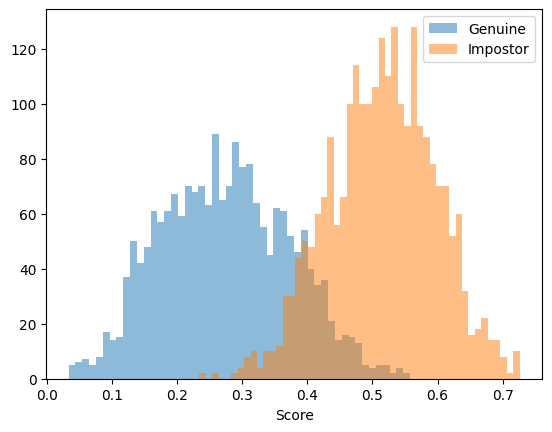

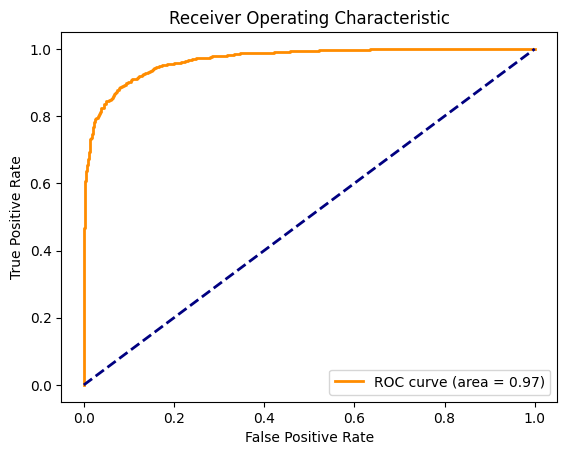

In [9]:

# Histograms
plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine')
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor')
plt.xlabel('Score')
plt.legend()
plt.show()

# ROC Curve
inverted_genuine = [1 - x for x in genuine_scores]
inverted_impostor = [1 - x for x in impostor_scores]

fpr, tpr, thresholds = roc_curve([0] * len(inverted_impostor) + [1] * len(inverted_genuine), inverted_impostor + inverted_genuine)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [10]:

# ROC AUC
print(f"ROC AUC: {roc_auc:.2f}")

# d-prime
genuine_mean = np.mean(inverted_genuine)
impostor_mean = np.mean(inverted_impostor)
genuine_std = np.std(inverted_genuine)
impostor_std = np.std(inverted_impostor)

d_prime = (genuine_mean - impostor_mean) / np.sqrt(0.5 * (genuine_std**2 + impostor_std**2))
print(f"d-prime: {d_prime:.2f}")


ROC AUC: 0.97
d-prime: 2.66


Additional tasks.


In [11]:
test_images = np.load('/kaggle/input/cs5567-model-and-numpy-data/numpy_data/test_images.npy')
train_images = np.load('/kaggle/input/cs5567-model-and-numpy-data/numpy_data/train_images.npy')
val_images = np.load('/kaggle/input/cs5567-model-and-numpy-data/numpy_data/val_images.npy')

# Extract features
train_features = feature_extractor.predict(train_images)
val_features = feature_extractor.predict(val_images)
test_features = feature_extractor.predict(test_images)

# Assuming that the last dimension of the features represents the actual features
train_features_reshaped = train_features.reshape(train_features.shape[0], -1)
val_features_reshaped = val_features.reshape(val_features.shape[0], -1)
test_features_reshaped = test_features.reshape(test_features.shape[0], -1)

# Initialize PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance

# Fit PCA on reshaped training features
pca.fit(train_features_reshaped)

# Transform the reshaped features using the fitted PCA
train_pca = pca.transform(train_features_reshaped)
val_pca = pca.transform(val_features_reshaped)
test_pca = pca.transform(test_features_reshaped)



In [12]:
pca_features = test_pca  # Replace with appropriate PCA features
pca_labels = test_labels  # Load your labels

biometric_templates_dict = {}

for i, label in enumerate(pca_labels):
    label_idx = np.argmax(label)  # Assuming one-hot encoding
    if label_idx not in biometric_templates_dict:
        biometric_templates_dict[label_idx] = []
    biometric_templates_dict[label_idx].append(pca_features[i])

In [13]:
genuine_scores = []
impostor_scores = []

# Iterate over each identity
for identity, templates in biometric_templates_dict.items():
    enrollment_template = templates[0].flatten()  # Flatten the first image for enrollment

    # Genuine scores
    for verification_template in templates[1:]:  # Flatten next images for verification
        verification_template_flat = verification_template.flatten()
        score = 1 - cosine_similarity([enrollment_template], [verification_template_flat])[0][0]
        genuine_scores.append(score)

    # Impostor scores
    for other_identity, other_templates in biometric_templates_dict.items():
        if other_identity != identity:  # Ensure different identity
            other_template_flat = other_templates[0].flatten()  # Flatten the impostor template
            impostor_score = 1 - cosine_similarity([enrollment_template], [other_template_flat])[0][0]
            impostor_scores.append(impostor_score)

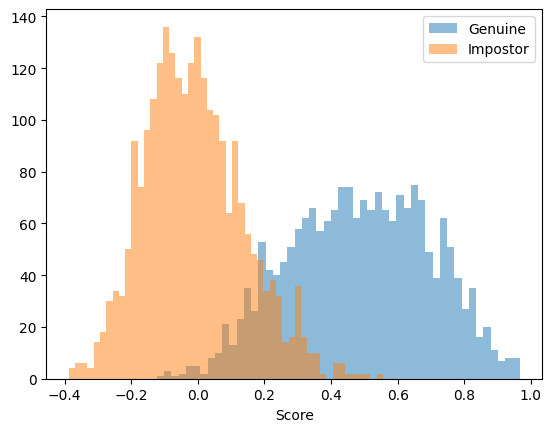

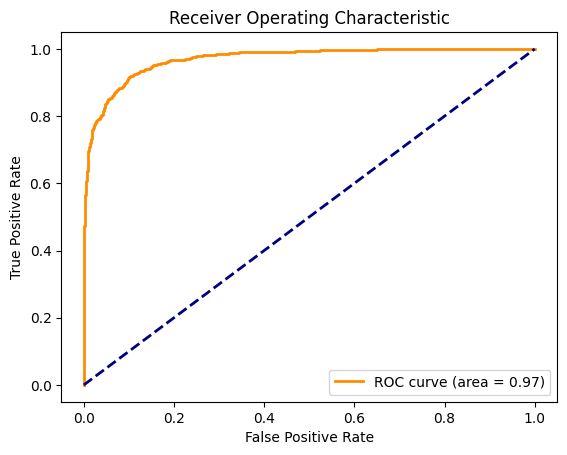

In [14]:
plt.hist([1 - x for x in genuine_scores], bins=50, alpha=0.5, label='Genuine')
plt.hist([1 - x for x in impostor_scores], bins=50, alpha=0.5, label='Impostor')
plt.xlabel('Score')
plt.legend()
plt.show()

inverted_genuine = [1 - x for x in genuine_scores]
inverted_impostor = [1 - x for x in impostor_scores]

fpr, tpr, thresholds = roc_curve([0] * len(inverted_impostor) + [1] * len(inverted_genuine), inverted_impostor + inverted_genuine)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# ROC AUC
print(f"ROC AUC: {roc_auc:.2f}")

# d-prime
genuine_mean = np.mean(inverted_genuine)
impostor_mean = np.mean(inverted_impostor)
genuine_std = np.std(inverted_genuine)
impostor_std = np.std(inverted_impostor)

d_prime = (genuine_mean - impostor_mean) / np.sqrt(0.5 * (genuine_std**2 + impostor_std**2))
print(f"d-prime: {d_prime:.2f}")

ROC AUC: 0.97
d-prime: 2.72


In [16]:
probe_pca = []
gallery_pca = []
probe_labels = []
gallery_labels = []

# Assuming each identity has more than one image and they are ordered in your dataset
for i in range(0, len(test_pca), 5):  # Adjust based on your dataset structure
    probe_pca.append(test_pca[i])
    probe_labels.append(test_labels[i])
    gallery_pca.extend(test_pca[i+1:i+5])  # Assuming 4 images per identity in gallery
    gallery_labels.extend(test_labels[i+1:i+5])

# Convert to numpy arrays for consistency
probe_pca = np.array(probe_pca)
gallery_pca = np.array(gallery_pca)
probe_labels = np.array(probe_labels)
gallery_labels = np.array(gallery_labels)


rank_1_accuracy, rank_5_accuracy = calculate_rank_accuracy(probe_pca, gallery_pca, probe_labels, gallery_labels)

print(f"Rank 1 Accuracy: {rank_1_accuracy}")
print(f"Rank 5 Accuracy: {rank_5_accuracy}")

Rank 1 Accuracy: 1.0
Rank 5 Accuracy: 1.0


In [17]:
similarity_scores, labels = calculate_similarity_scores(probe_pca, gallery_pca, probe_labels, gallery_labels)

# Use these scores and labels to calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels, similarity_scores)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
optimal_threshold = thresholds[optimal_idx]

# Filter the gallery based on the threshold
filtered_gallery_scores = [score for score in similarity_scores if score >= optimal_threshold]
filtered_labels = [labels[i] for i, score in enumerate(similarity_scores) if score >= optimal_threshold]



In [26]:
# Recalculate rank 1 and rank 5 accuracy with the filtered scores
rank_1_accuracy_filtered, rank_5_accuracy_filtered = calculate_rank_accuracy_from_scores(filtered_gallery_scores, filtered_labels)

print(f"Rank 1 Accuracy (Filtered): {rank_1_accuracy_filtered}")
print(f"Rank 5 Accuracy (Filtered): {rank_5_accuracy_filtered}")

Rank 1 Accuracy (Filtered): 1
Rank 5 Accuracy (Filtered): 1
